## Python Econometric Implementation

### Packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from linearmodels.panel import PanelOLS
import geopandas as gpd

### Inputs

In [2]:
file_path_data = f'/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/unused_scripts/10_4231_Q07D-J369/soilMoistureData.dta'
usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"
soil_moisture_data = pd.read_stata(file_path_data)
usda_pd = pd.read_csv(usda_filepath)

### Preprocessing

In [3]:
# pads usda_pd with zeros, and subsets
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]
# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')
# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]

usda_pd['log_yield'] = np.log(usda_pd['yield'])

soil_moisture_data['fips'] = soil_moisture_data['fips'].astype(float).astype(int).astype(str).str.zfill(5)
soil_moisture_data['fips'] = soil_moisture_data['fips'].astype(int).astype(str).str.zfill(5)
soil_moisture_data['state'] = soil_moisture_data['fips'].str.slice(0, 2)

# merge usda_pd & livneh_pd 
df = soil_moisture_data.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
df['year2'] = df['year']**2

rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                   "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                   "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                   "46", "47", "48", "50", "51", "54", "55"]

df = df[df['state'].isin(rainfed_states)]


## Econometric Model Implementation non-pyWBM

### Schelnker & Roberts 2009

In [7]:
# https://www.pnas.org/doi/10.1073/pnas.0906865106
# We use county-level trends and then model the year-to-year variations
# via growing degree days (GDD), extreme degree days (EDD), season-total precip (prcp)
# and season-total precip squared (prcp2)
fips_number = '17113'
df_set_index = df.set_index(['fips', 'year'])

# Define the model with both entity and time fixed effects
model = PanelOLS.from_formula('log_yield ~ GDD + EDD + prcp + prcp2 + EntityEffects + TimeEffects', data=df_set_index)

# Fit the model
results_sr09 = model.fit()

In [18]:
GDD_param = results_sr09.params.GDD.item()
EDD_param = results_sr09.params.EDD.item()
prcp_param = results_sr09.params.prcp.item()
prcp2_param = results_sr09.params.prcp2.item()
entity_effect = results_sr09.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values
df_fip_01001 = df[df['fips'] == f'{fips_number}']
model_predication_sr09 = (GDD_param * df_fip_01001['GDD'] + 
                     EDD_param * df_fip_01001['EDD'] + 
                     prcp_param * df_fip_01001['prcp'] + 
                     prcp2_param * df_fip_01001['prcp2'] +
                    entity_effect)

## Haqiqi et al. 2021

In [4]:
# https://hess.copernicus.org/articles/25/551/2021/hess-25-551-2021.pdf
# Again use county-level trends, now model the year-to-year variations
# via growing degree days (GDD), extreme degree days conditioned on soil moisture buckets,
# season-average soil moisture (SM_mean) and season-average soil squared (SM_mean2)
output_dir = "/storage/home/cta5244/work/avila_et_al_2026_pyWBM_yield/0_uncertainity_figures/fips_nonpywbm_models"

### Plotting

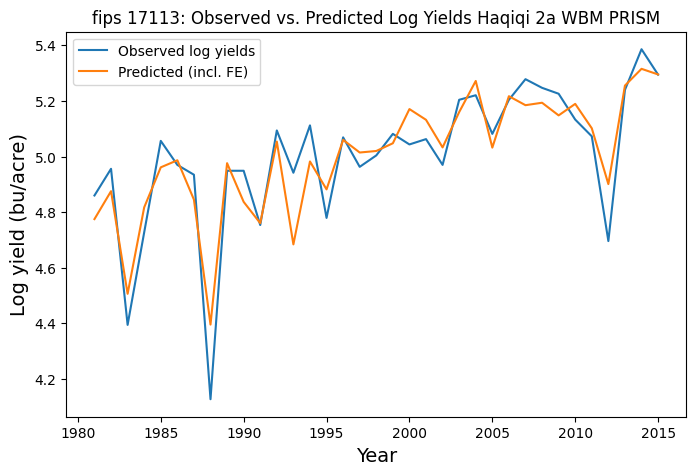

In [10]:
fips_number = '17113'
df_set_index = df.set_index(['fips', 'year'])
df_set_index['year'] = df_set_index['year2']**(1/2)
df_set_index['mrso2'] = df_set_index['mrso']**2

formula = ('log_yield ~ dday10_29C + gdd29smxxx_75b + gdd29sm75b_25b + gdd29sm25b_25a + gdd29sm25a_75a + gdd29sm75a_xxx + mrso + mrso2 + C(state):year + C(state):year2 + EntityEffects')

model = PanelOLS.from_formula(formula, data=df_set_index)
results_h21 = model.fit(cov_type='clustered', clusters=df_set_index['state'])
predictions = results_h21.predict(effects=True)
predictions['total_pred'] = predictions['fitted_values'] + predictions['estimated_effects']

fips_number = '17113'
mclean_county_plot = predictions.loc[fips_number]
corn_yields = df_set_index.loc[fips_number, 'log_yield']

plt.figure(figsize=(8,5))
plt.plot(mclean_county_plot.index, corn_yields, label='Observed log yields')
plt.plot(mclean_county_plot.index, mclean_county_plot['total_pred'], label='Predicted (incl. FE)')
plt.title(f'fips {fips_number}: Observed vs. Predicted Log Yields Haqiqi 2a WBM PRISM')
plt.ylabel('Log yield (bu/acre)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.legend()

Text(0.5, 1.0, 'Fixed Effects Haqiqi Model 2a, Year / Year^2 WBM PRISM')

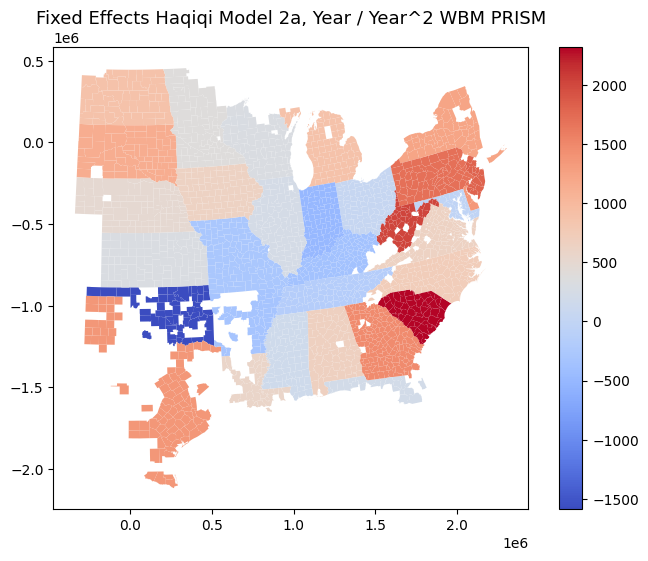

In [11]:
results_df = results_h21.estimated_effects['estimated_effects']
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"
counties = gpd.read_file(county_shp_path)
averaged_results = results_df.groupby('fips').mean()
merged = counties.merge(averaged_results, how='left', left_on='fips', right_on='fips')

fig, ax = plt.subplots(figsize=(8, 6))
merged.plot(column='estimated_effects', cmap='coolwarm', ax=ax, legend=True)
ax.set_title('Fixed Effects Haqiqi Model 2a, Year / Year^2 WBM PRISM', fontsize=13)


In [12]:
results_h21

Dep. Variable:,log_yield,R-squared:,0.5088
Estimator:,PanelOLS,R-squared (Between):,-3.998e+04
No. Observations:,65013,R-squared (Within):,0.5088
Date:,"Wed, Mar 26 2025",R-squared (Overall):,-3.512e+04
Time:,13:56:46,Log-likelihood,1.153e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,928.54
Entities:,2191,P-value,0.0000
Avg Obs:,29.673,Distribution:,"F(70,62752)"
Min Obs:,1.0000,,
Max Obs:,35.000,F-statistic (robust):,4.167e+17


## Weather Only Coefficients

In [67]:
fips_number = '17113'
df_set_index = df.set_index(['fips', 'year'])
df_set_index['year'] = df_set_index['year2']**(1/2)

model = PanelOLS.from_formula(
    'log_yield ~ GDD + EDD_SM_75_below + EDD_SM_25_75_below + EDD_SM_0_25_norm + EDD_SM_25_75_above + EDD_SM_75_above + SM_mean + SM_mean2 + EntityEffects',
    data=df_set_index)

# fit the model
results_h21 = model.fit()

GDD_param = results_h21.params.GDD.item()
EDD_SM_75_below_param = results_h21.params.EDD_SM_75_below.item()
EDD_SM_25_75_below_param = results_h21.params.EDD_SM_25_75_below.item()
EDD_SM_0_25_norm_param = results_h21.params.EDD_SM_0_25_norm.item()
EDD_SM_25_75_above_param = results_h21.params.EDD_SM_25_75_above.item()
EDD_SM_75_above_param = results_h21.params.EDD_SM_75_above.item()
SM_mean_param = results_h21.params.SM_mean.item()
SM_mean2_param = results_h21.params.SM_mean2.item()
entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values

fips_number = '17113'

entity_effect = results_h21.estimated_effects['estimated_effects'].loc[f'{fips_number}'].values

df_fip_01001 = df[df['fips'] == f'{fips_number}']

model_predication_h21 = (GDD_param * df_fip_01001['GDD'] + 
                     EDD_SM_75_below_param * df_fip_01001['EDD_SM_75_below'] + 
                     EDD_SM_25_75_below_param * df_fip_01001['EDD_SM_25_75_below'] + 
                     EDD_SM_0_25_norm_param * df_fip_01001['EDD_SM_0_25_norm'] +
                     EDD_SM_25_75_above_param * df_fip_01001['EDD_SM_25_75_above'] +
                     EDD_SM_75_above_param * df_fip_01001['EDD_SM_75_above'] +
                     SM_mean_param * df_fip_01001['SM_mean'] +
                     SM_mean2_param * df_fip_01001['SM_mean2'] +
                    entity_effect)



In [68]:
results_h21

Dep. Variable:,log_yield,R-squared:,0.1530
Estimator:,PanelOLS,R-squared (Between):,0.8295
No. Observations:,122613,R-squared (Within):,0.1530
Date:,"Wed, Mar 26 2025",R-squared (Overall):,0.8209
Time:,00:02:02,Log-likelihood,-6.994e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2718.0
Entities:,2215,P-value,0.0000
Avg Obs:,55.356,Distribution:,"F(8,120390)"
Min Obs:,26.000,,
Max Obs:,64.000,F-statistic (robust):,2718.0


In [77]:
file_path_data = f'/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/unused_scripts/10_4231_Q07D-J369/soilMoistureData.dta'
iman_files = pd.read_stata(file_path_data)
iman_files.loc[iman_files['fips'] == 1001]

,fips,year,longitude,latitude,cornYield,cornArea,dday10C,dday29C,dday10_29C,prec,...,mrsoJunJul2,mrsoAugSep2,smf2,et2,mrso_alt2,shrDD29nl,shrDD10_29nl,d10,d90,irAreaShr
0,1001.0,1981.0,-86.607887,32.480659,17.307692,5200.0,2592.810271,127.139054,2465.671143,532.793152,...,6.032003,31.760704,0.842087,0.007865,182.538193,0.976466,0.933599,0.0,1.0,0.0
1,1001.0,1982.0,-86.607887,32.480659,59.090908,2200.0,2536.988700,94.831912,2442.156738,668.478088,...,22.017933,6.829196,0.820522,0.009093,233.104965,0.977765,0.945156,0.0,1.0,0.0
2,1001.0,1983.0,-86.607887,32.480659,38.000000,2000.0,2397.895649,108.080379,2289.815186,772.061939,...,19.277542,31.974390,0.844767,0.010975,364.171814,0.985346,0.909774,0.0,1.0,0.0
3,1001.0,1984.0,-86.607887,32.480659,41.200001,2500.0,2386.556382,87.552724,2299.003662,645.942825,...,4.926238,15.114095,0.832785,0.007721,197.016693,0.984843,0.924855,0.0,1.0,0.0
4,1001.0,1985.0,-86.607887,32.480659,56.521740,2300.0,2569.852095,105.405256,2464.446777,574.620335,...,11.005151,29.181656,0.772442,0.008333,151.991440,0.961104,0.942715,0.0,1.0,0.0
5,1001.0,1986.0,-86.607887,32.480659,38.500000,2000.0,2684.764955,145.721282,2539.043701,516.306026,...,9.521318,19.895382,0.765625,0.006257,110.656403,0.985279,0.935403,0.0,1.0,0.0
6,1001.0,1987.0,-86.607887,32.480659,47.692307,1300.0,2630.831975,128.999898,2501.832031,482.389183,...,27.233038,4.078056,0.821209,0.006256,149.942902,0.955570,0.935515,0.0,1.0,0.0
7,1001.0,1988.0,-86.607887,32.480659,20.000000,500.0,2511.912194,100.819433,2411.092773,684.454195,...,27.595736,29.390814,0.825228,0.006551,206.090469,0.904437,0.852897,0.0,1.0,0.0
8,1001.0,1989.0,-86.607887,32.480659,62.500000,1200.0,2476.089904,89.707153,2386.382812,842.361343,...,76.015488,11.228035,0.867097,0.009642,300.221161,0.935815,0.873579,0.0,1.0,0.0
9,1001.0,1990.0,-86.607887,32.480659,51.333332,1500.0,2614.236663,167.004752,2447.231934,403.667337,...,8.720131,0.029884,0.806615,0.004357,89.525528,0.997972,0.979329,0.0,1.0,0.0
